# **<font color='teal'> FACIAL EXPRESSION RECOGNITION (CNN) </font>**


![Alt text](https://media.licdn.com/dms/image/D4D12AQG0fzAiLEY_pA/article-cover_image-shrink_720_1280/0/1696582192307?e=2147483647&v=beta&t=Nypu_YZ6GL2nn93eENuhTNPZZzA-snyR1SDnM5OoUyo)

#### **<font color='teal'> DataSet </font>**

https://www.kaggle.com/competitions/challenges-in-representation-learning-facial-expression-recognition-challenge/data?select=icml_face_data.csv


<font color='blue'>This datasets consists of grayscale images of faces, each with a resolution of 48x48 pixels. The goal is to classify these faces into one of seven emotion categories:

<font color='blue'>* 0=Angry</font>

<font color='blue'>* 1=Disgust</font>

<font color='blue'>* 2=Fear</font>

<font color='blue'>* 3=Happy</font>

<font color='blue'>* 4=Sad</font>

<font color='blue'>* 5=Surprise</font>

<font color='blue'>* 6=Neutral</font>

<font color='blue'>The dataset is structured with two columns:</font>

<font color='blue'>* **"emotion"**: This column contains numeric codes ranging from 0 to 6, representing the corresponding emotion category for each image.</font>

<font color='blue'>* **"pixels"**: The "pixels" column is a string with space-separated pixel values arranged in row-major order. This string encodes the image's </font><font color='blue'>pixel values, which are used for visualizing and analyzing the facial expressions.</font>

<font color='blue'>The objective is to build a machine learning model to accurately classify these facial expressions into their respective emotion categories based on the given pixel values.</font>

### **<font color='teal'> 1. Sourcing and Loading the Data </font>**

##### **<font color='teal'> 1.1. Importing Libraries </font>**

In [155]:
#!pip install tensorflow

In [156]:
!pip install jupyterthemes

In [157]:
# Importing and checking the version of Tensor Flow.
import tensorflow as tf
tf.version.VERSION

'2.14.0'

In [158]:
import cv2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import pickle
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from scipy import ndimage
import cv2  # OpenCV for flipping and scaling

#from jupyterthemes import jtplot
#jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False) 

##### **<font color='teal'> 1.2. Loading the data </font>**

In [159]:
# Reading and checking the CSV file
df=pd.read_csv("../data/icml_face_data.csv")
df

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...


### **<font color='teal'> 2. Exploring the Data </font>**

##### **<font color='teal'> 2.1. Renaming Column Name </font>**

In [160]:
# 'pixels' column has space in the csv file so we are removing that space .
df = df.rename(columns={' pixels': 'pixels'})

In [161]:
df['pixels'][2]

'231 212 156 164 174 138 161 173 182 200 106 38 39 74 138 161 164 179 190 201 210 216 220 224 222 218 216 213 217 220 220 218 217 212 174 160 162 160 139 135 137 131 94 56 36 44 27 16 229 175 148 173 154 151 171 172 183 101 23 25 67 127 164 170 171 182 199 212 219 220 224 226 226 226 226 226 227 227 228 225 221 217 202 174 158 155 145 126 126 129 99 70 37 27 35 27 214 156 157 168 153 172 168 175 100 16 8 47 117 169 175 175 183 194 204 214 218 223 225 227 228 226 229 231 232 232 229 227 225 224 217 198 174 154 134 110 97 115 96 69 52 28 22 28 202 153 166 156 164 166 170 116 26 2 21 90 165 180 180 181 192 206 210 213 216 220 224 224 226 224 228 227 227 228 231 229 225 228 226 218 196 168 148 111 80 89 97 56 50 38 26 23 190 163 167 156 168 172 136 36 0 24 69 146 180 179 183 196 204 211 214 215 214 217 218 217 220 223 220 220 222 224 227 229 228 228 228 227 216 187 156 125 92 62 83 61 44 46 31 31 181 173 156 167 176 159 61 0 8 62 121 175 185 188 197 210 215 222 225 221 216 214 214 214 213 

In [162]:
df.shape

(35887, 2)

##### **<font color='teal'> 2.2. Converting pixel values in string format to array format </font>**

In [163]:
# function to convert pixel values in string format to array format
def string2array(x):
  return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

In [164]:
df['pixels'] = df['pixels'].apply(lambda x: string2array(x))

In [165]:
type(df['pixels'][2])

numpy.ndarray

In [166]:
df['pixels'][2].shape

(48, 48, 1)

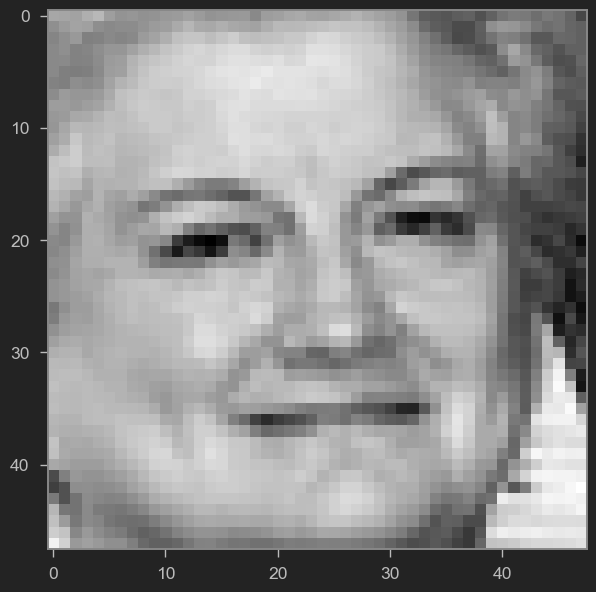

In [167]:
# Visualizing the first image within the dataframe ,just to make sure that the reshaping process does not cause distortion.
plt.imshow(df['pixels'][100],cmap='gray')

##### **<font color='teal'> 2.3. Checking for Null Values </font>**

In [168]:
df.isna().sum()

emotion    0
pixels     0
dtype: int64

In [169]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad',5:'Surprise', 6:'Neutral'} 

##### **<font color='teal'> 2.4. Checking No of Samples in each Emotion </font>**

In [170]:
emotions_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad',5:'Surprise', 6:'Neutral'} 

a = df['emotion'].value_counts().rename('Count')
b = (df['emotion'].value_counts(normalize=True) * 100).rename('Distribution')

temp = pd.concat([a, b], axis=1)
temp.index = [emotions_labels[i] for i in temp.index]
temp

,Count,Distribution
Happy,8989,25.048068
Neutral,6198,17.270878
Sad,6077,16.933709
Fear,5121,14.269791
Angry,4953,13.801655
Surprise,4002,11.151671
Disgust,547,1.524229


<Figure size 3000x1000 with 0 Axes>

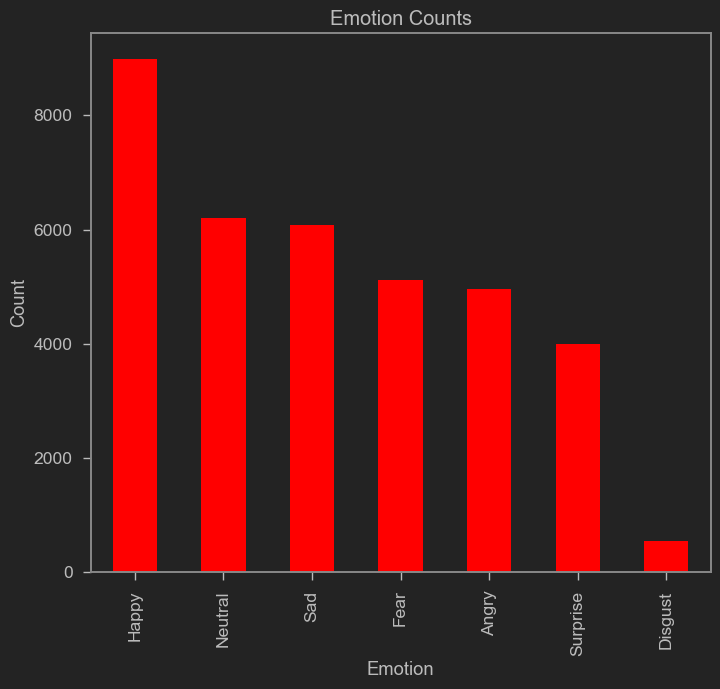

In [171]:
plt.figure(figsize=(30,10))
temp.plot(y='Count', kind='bar', legend=False,color='red')  # Plot the 'Count' column as a bar chart

# Set the title and labels
plt.title('Emotion Counts')
plt.xlabel('Emotion')
plt.ylabel('Count')

# Display the plot
plt.show()

**<font color='blue'> We can clearly see that the data is Imbalanced </font>**

**<font color='blue'> We will then apply data augmentation Techniques to balance the data  </font>**

##### **<font color='teal'> 2.5. Checking a Sample in each Emotion </font>**

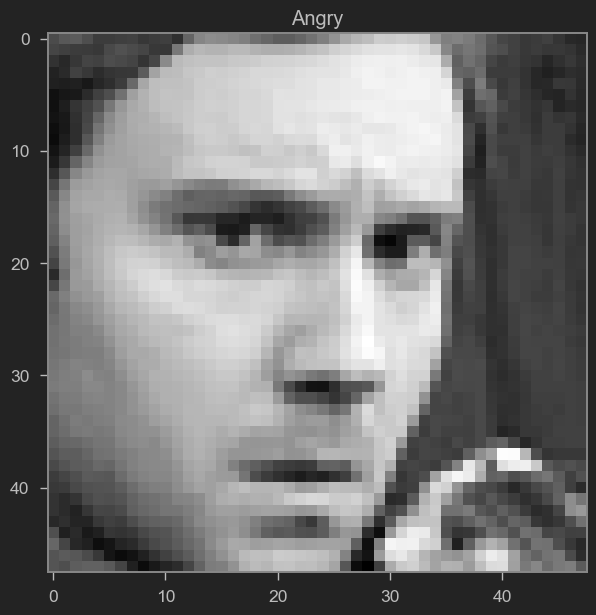

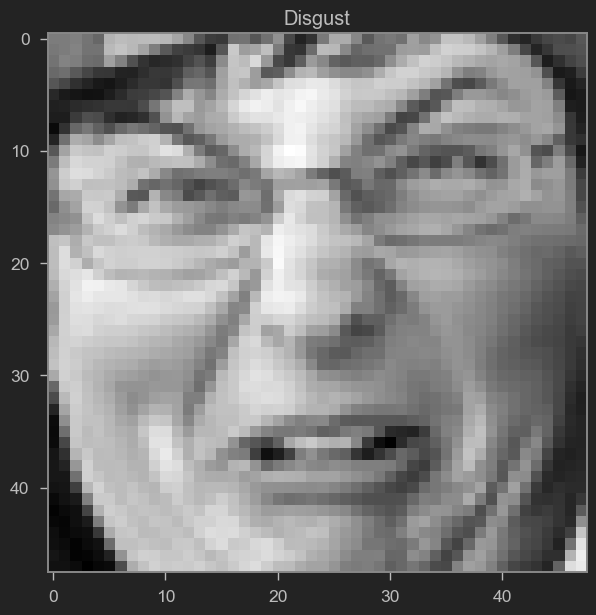

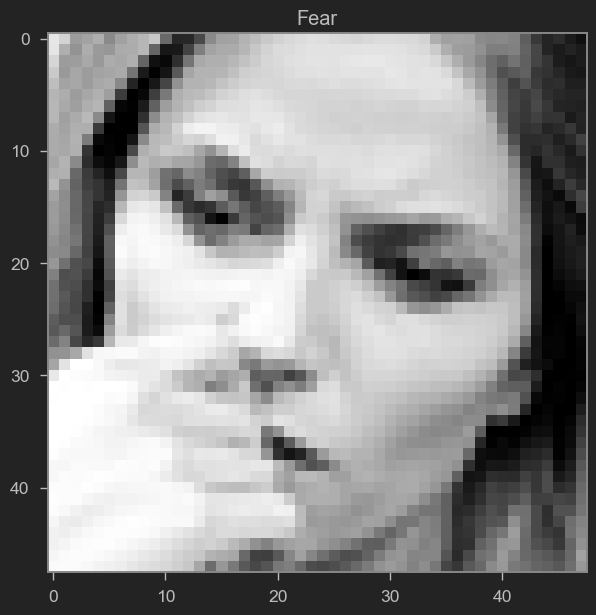

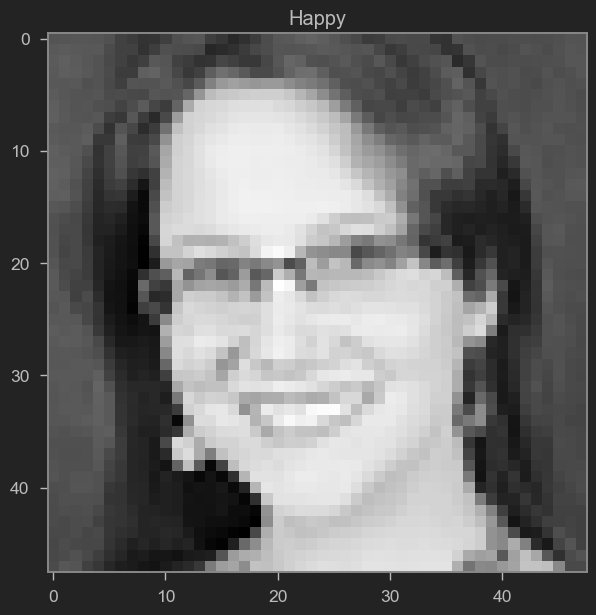

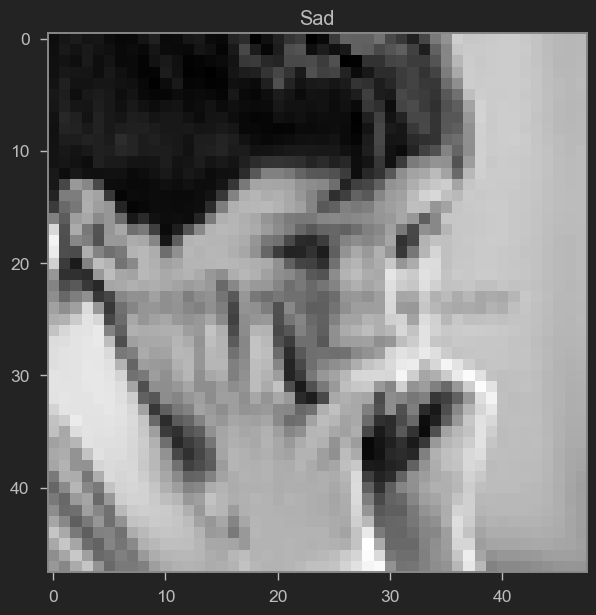

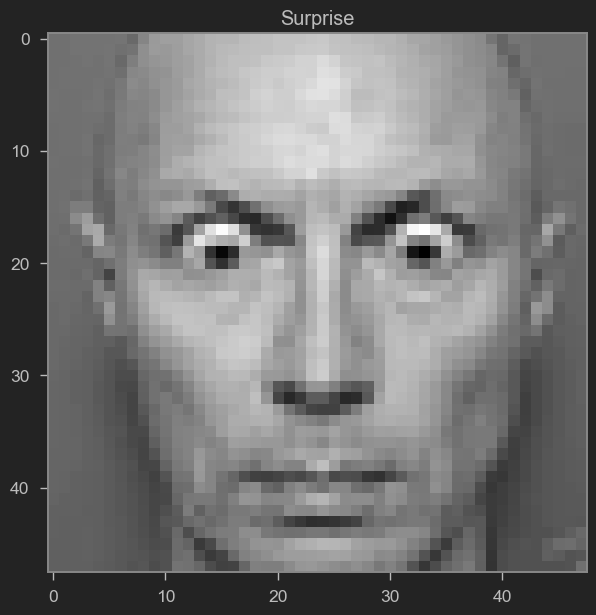

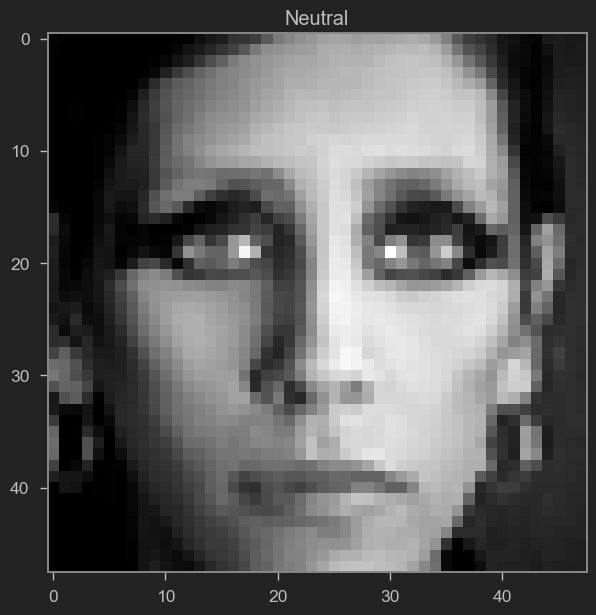

In [172]:
emotions_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad',5:'Surprise', 6:'Neutral'} 
emotions = [0,1,2,3,4,5,6]

for i in emotions:
  data = df[df['emotion'] == i][:1]
  img = data['pixels'].item()
  img = img.reshape(48,48)
  plt.figure()
  plt.title(emotions_labels[i])
  plt.imshow(img, cmap= 'gray')

### **<font color='teal'> 3. Image Augmentation </font>**

**<font color='blue'>Image augmentation is a technique used in machine learning and computer vision to artificially increase the size of a training dataset by applying various transformations to the original data. These transformations include operations like rotating, flipping, scaling, cropping, adjusting brightness or contrast, and more. Data augmentation is commonly used when training machine learning models, particularly deep learning models for image classification, object detection, and other tasks. By applying these transformations to the existing data, the model becomes more robust and generalizes better to real-world scenarios, as it has learned to recognize objects or patterns from various perspectives and conditions.</font>**

![Alt text](https://www.researchgate.net/publication/319413978/figure/fig2/AS:533727585333249@1504261980375/Data-augmentation-using-semantic-preserving-transformation-for-SBIR.png)

##### **<font color='teal'> 3.1. Creating Image Augmentation Function </font>**

In [173]:
def image_augmentation(augmentation_num,Images,emotion_label):
    # Define the number of augmented images you want per input image
    num_augmentations = augmentation_num

    # Create an array to store augmented images
    augmented_images = []

    # Loop through each input image
    for image in Images:
        # Ensure that each image has a consistent shape (48, 48)
        image = image.reshape(48, 48,1)

        for _ in range(num_augmentations):
            # Rotate the image by a random angle between -20 and 20 degrees
            rotated_image = ndimage.rotate(image, np.random.uniform(-20, 20), reshape=False)

            # Flip the image horizontally (left to right) with a 50% probability
            if np.random.choice([True, False]):
                rotated_image = np.fliplr(rotated_image)
            
            # Append the augmented image to the list
            augmented_images.append(rotated_image)

    
    # Create a DataFrame for the augmented data
    augmented_df = pd.DataFrame({'emotion': emotion_label, 'pixels': augmented_images})
    return augmented_df
            



##### **<font color='teal'> 3.2. Data Augmentation for Disgust Images </font>**

In [174]:
disgust_images=df[df['emotion']==1]
augmented_disgust=image_augmentation(15,disgust_images['pixels'],1)
df = pd.concat([df, augmented_disgust], ignore_index=True)


##### **<font color='teal'> 3.3. Data Augmentation for Surprise Images </font>**

In [192]:
surprise_images=df[df['emotion']==5]
augmented_surprise=image_augmentation(1,surprise_images['pixels'],5)
df = pd.concat([df, augmented_surprise], ignore_index=True)

##### **<font color='teal'> 3.3. Data Augmentation for Angry Images </font>**

In [176]:
angry_images=df[df['emotion']==0]
augmented_angry=image_augmentation(1,angry_images['pixels'],0)
df = pd.concat([df, augmented_angry], ignore_index=True)

In [177]:
df.tail()

,emotion,pixels
53042,0,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [3..."
53043,0,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
53044,0,"[[[0.0], [0.0], [0.0], [0.0], [116.56336], [18..."
53045,0,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
53046,0,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."


In [178]:
emotions_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad',5:'Surprise', 6:'Neutral'} 

a = df['emotion'].value_counts().rename('Count')
b = (df['emotion'].value_counts(normalize=True) * 100).rename('Distribution')

temp = pd.concat([a, b], axis=1)
temp.index = [emotions_labels[i] for i in temp.index]
temp

,Count,Distribution
Angry,9906,18.674006
Happy,8989,16.945350
Disgust,8752,16.498577
Surprise,8004,15.088506
Neutral,6198,11.683978
Sad,6077,11.455879
Fear,5121,9.653703


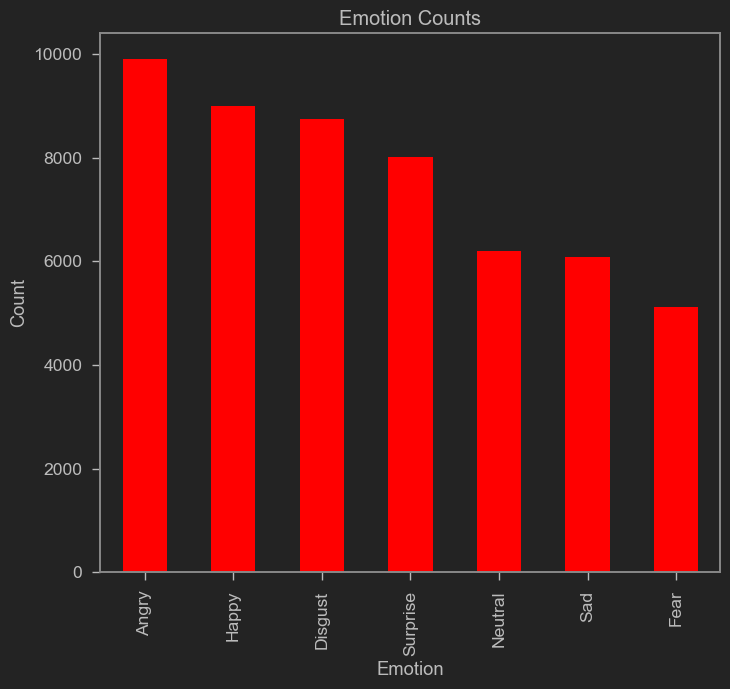

In [179]:
temp.plot(y='Count', kind='bar', legend=False,color='red')  # Plot the 'Count' column as a bar chart

# Set the title and labels
plt.title('Emotion Counts')
plt.xlabel('Emotion')
plt.ylabel('Count')

# Display the plot
plt.show()

**<font color='blue'> Now, the dataset is well-balanced, ensuring that each class has a nearly equal number of samples. </font>**

### **<font color='teal'> 4. Splitting The Data </font>**

In [180]:
X = df['pixels']
y = pd.get_dummies(df['emotion'])

X = np.stack(X, axis = 0)
X = X.reshape(df.shape[0], 48, 48, 1)

print(X.shape, y.shape)

(53047, 48, 48, 1) (53047, 7)


In [181]:
X = np.array(X)
y = np.array(y)

In [187]:
# spliting the dataframe in to train,test and validation data frames

from sklearn.model_selection import train_test_split

X_train, X_Test, y_train, y_Test = train_test_split(X,y,test_size = 0.2, shuffle = True)
X_val, X_Test, y_val, y_Test = train_test_split(X_Test,y_Test, test_size = 0.5, shuffle = True)

In [188]:
print(X_train.shape, y_train.shape)

(42437, 48, 48, 1) (42437, 7)


In [189]:
print(X_Test.shape, y_Test.shape)

(5305, 48, 48, 1) (5305, 7)


In [190]:
print(X_val.shape, y_val.shape)

(5305, 48, 48, 1) (5305, 7)


### **<font color='teal'> 5. Normalization </font>**

<font color='blue'>When you divide the pixel values by 255, you are effectively normalizing the pixel values in each image to a range between 0 and 1. This is a common practice in image processing and machine learning for several reasons:</font>

<font color='blue'>* Numerical Stability: It ensures that pixel values are within a reasonable numerical range. This can help with the numerical stability of algorithms during training and processing.</font>

<font color='blue'>* Consistency: Normalizing pixel values to a common range (0 to 1) makes it easier for machine learning algorithms to learn patterns across different images.</font>

<font color='blue'>* Convergence: It can help improve the convergence of optimization algorithms used in training deep neural networks. Optimization algorithms often work more effectively with small input values.</font>

<font color='blue'>* Regularization: Normalization can also act as a form of regularization, helping to prevent overfitting during training.</font>

<font color='blue'>Overall, this preprocessing step can help improve the performance and convergence of machine learning models, particularly when dealing with image data. It's important to note that scaling the pixel values by 255 is specifically done to normalize images where the pixel values typically range from 0 to 255, which is common in grayscale images. For color images, a similar normalization might be done with pixel values ranging from 0 to 255 for each color channel (red, green, and blue)</font>







In [191]:
X_train = X_train/255
X_val   = X_val /255
X_Test  = X_Test/255

### **<font color='teal'> 6. BUILD AND TRAIN DEEP LEARNING MODEL FOR FACIAL EXPRESSION CLASSIFICATION </font>**